In [1]:
# --- 1. Imports et Configuration ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:

# Astuce pour importer nos modules src/ depuis un notebook
# On ajoute le répertoire parent au chemin de recherche de Python
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import load_config
from src.data_preprocessing import clean_initial_data # On réutilise notre fonction de nettoyage


In [5]:
# Charger la configuration et les données brutes
# '..' signifie "remonter d'un niveau"
config_path = '../params.yml'
config = load_config(config_path)

# La suite de votre code devrait maintenant fonctionner
raw_df = pd.read_csv(config['data']['raw_data_path'])
print("Setup terminé. Données chargées.")

Configuration loaded successfully from ../params.yml
Setup terminé. Données chargées.


In [6]:
# --- 2. Créer notre DataFrame de base nettoyé ---
# On applique le nettoyage initial que nous avons déjà défini
df_cleaned = clean_initial_data(raw_df.copy())
print("Données initiales nettoyées. Shape:", df_cleaned.shape)
print(df_cleaned.head())


Données initiales nettoyées. Shape: (7032, 20)
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1            No             DSL            Yes           No              Yes   
2            No             DSL            Yes          Yes               No   
3            No             DSL            Yes           No              Yes   
4            No     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies        Contract Paper

In [10]:
# --- 3. Création des Nouvelles Caractéristiques (Feature Engineering) ---

# Caractéristique 1 : Discrétisation de l'ancienneté (Tenure)
# Hypothèse : Le comportement de churn varie fortement selon que le client est nouveau, établi ou fidèle.
bins = [0, 12, 48, 73] # 0-1 an, 1-4 ans, > 4 ans
labels = ['New_Customer', 'Established_Customer', 'Loyal_Customer']
df_cleaned['tenure_group'] = pd.cut(df_cleaned['tenure'], bins=bins, labels=labels, right=False)
print("\nCaractéristique 'tenure_group' créée.")


Caractéristique 'tenure_group' créée.


In [11]:
print(df_cleaned['tenure_group'].isnull().sum())

0


In [12]:
print(df_cleaned['TotalCharges'].isnull().sum())

0


In [13]:
# Caractéristique 2 : Nombre de services additionnels
# Hypothèse : Les clients plus "investis" dans l'écosystème (avec plusieurs services) pourraient être moins susceptibles de partir.
additional_services = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
# On compte combien de ces services ont la valeur 'Yes'
df_cleaned['num_additional_services'] = df_cleaned[additional_services].apply(lambda x: (x == 'Yes').sum(), axis=1)
print("Caractéristique 'num_additional_services' créée.")

# Caractéristique 3 : Ratio des frais mensuels par rapport à l'ancienneté
# Hypothèse : Un client qui paie cher pour une courte période pourrait être plus sensible au prix et donc plus à risque.
# On ajoute 1 à 'tenure' pour éviter la division par zéro si un client a 0 mois (même si min=1 ici, c'est une bonne pratique)
df_cleaned['monthly_over_tenure_ratio'] = df_cleaned['MonthlyCharges'] / (df_cleaned['tenure'] + 1)
print("Caractéristique 'monthly_over_tenure_ratio' créée.")

print("\nAperçu du DataFrame avec les nouvelles caractéristiques :")
print(df_cleaned[['tenure', 'tenure_group', 'MonthlyCharges', 'num_additional_services', 'monthly_over_tenure_ratio', 'Churn']].head())



Caractéristique 'num_additional_services' créée.
Caractéristique 'monthly_over_tenure_ratio' créée.

Aperçu du DataFrame avec les nouvelles caractéristiques :
   tenure          tenure_group  MonthlyCharges  num_additional_services  \
0       1          New_Customer           29.85                        1   
1      34  Established_Customer           56.95                        2   
2       2          New_Customer           53.85                        2   
3      45  Established_Customer           42.30                        3   
4       2          New_Customer           70.70                        0   

   monthly_over_tenure_ratio  Churn  
0                  14.925000      0  
1                   1.627143      0  
2                  17.950000      1  
3                   0.919565      0  
4                  23.566667      1  



--- Analyse de 'tenure_group' ---


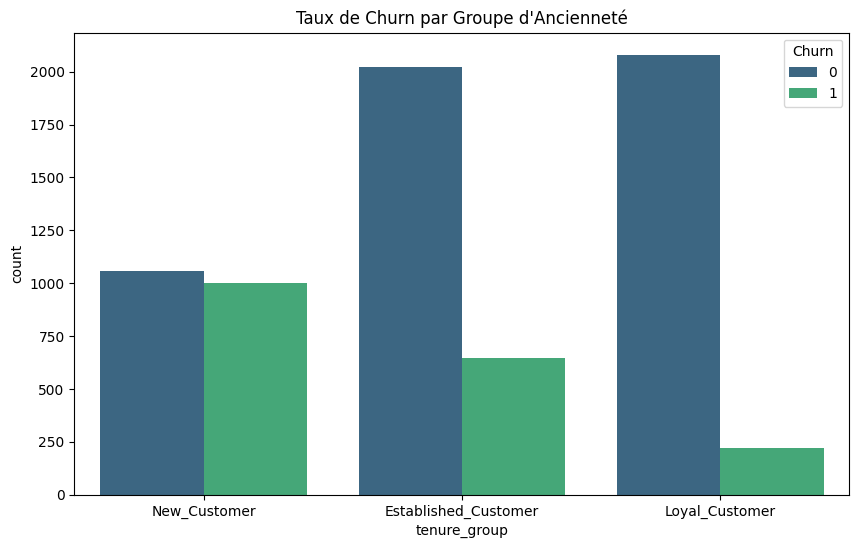

In [14]:
# --- 4. Analyse et Validation des Nouvelles Caractéristiques ---
# Si une nouvelle caractéristique est utile, sa distribution devrait être différente pour les clients "Churn" vs "Non-Churn".

print("\n--- Analyse de 'tenure_group' ---")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='tenure_group', hue='Churn', palette='viridis')
plt.title('Taux de Churn par Groupe d\'Ancienneté')
plt.show()
# On s'attend à voir un taux de churn beaucoup plus élevé pour les 'New_Customer'.



--- Analyse de 'num_additional_services' ---


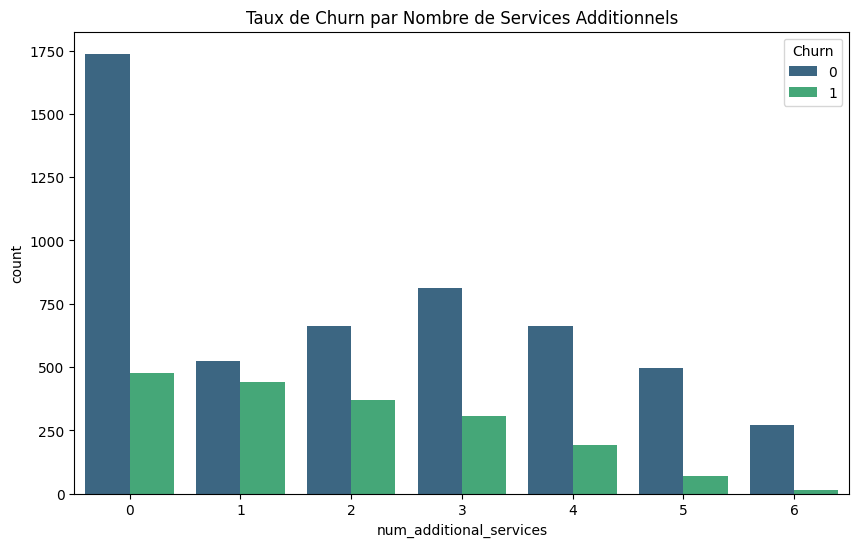

In [15]:
print("\n--- Analyse de 'num_additional_services' ---")
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='num_additional_services', hue='Churn', palette='viridis')
plt.title('Taux de Churn par Nombre de Services Additionnels')
plt.show()
# On peut s'attendre à ce que le churn diminue à mesure que le nombre de services augmente.



--- Analyse de 'monthly_over_tenure_ratio' ---


C:\Users\pc\AppData\Local\Temp\ipykernel_22092\3894989142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Churn', y='monthly_over_tenure_ratio', palette='viridis')


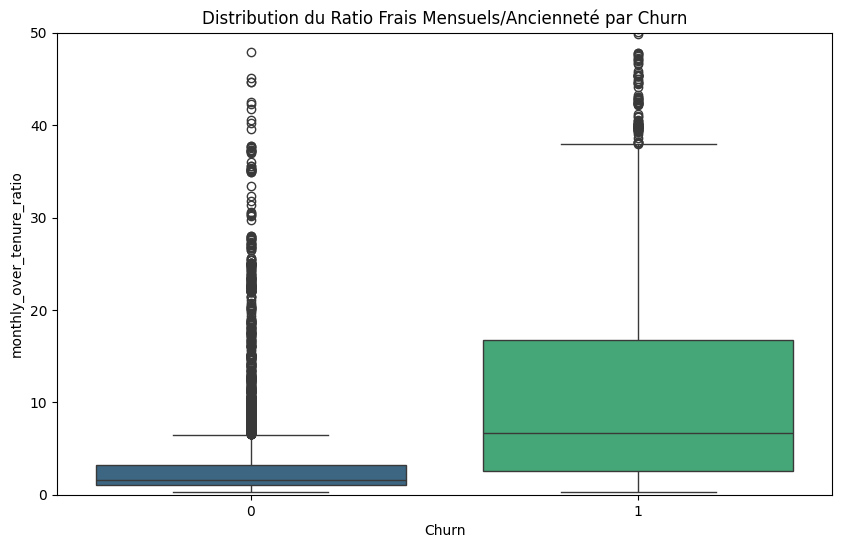

In [16]:



print("\n--- Analyse de 'monthly_over_tenure_ratio' ---")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='Churn', y='monthly_over_tenure_ratio', palette='viridis')
plt.title('Distribution du Ratio Frais Mensuels/Ancienneté par Churn')
plt.ylim(0, 50) # Zoomer sur la distribution principale
plt.show()
# On s'attend à ce que ce ratio soit plus élevé pour les clients qui churnent.

In [17]:
print(df_cleaned.isnull().sum())

gender                       0
SeniorCitizen                0
Partner                      0
Dependents                   0
tenure                       0
PhoneService                 0
MultipleLines                0
InternetService              0
OnlineSecurity               0
OnlineBackup                 0
DeviceProtection             0
TechSupport                  0
StreamingTV                  0
StreamingMovies              0
Contract                     0
PaperlessBilling             0
PaymentMethod                0
MonthlyCharges               0
TotalCharges                 0
Churn                        0
tenure_group                 0
num_additional_services      0
monthly_over_tenure_ratio    0
dtype: int64
